# 4- Exploration and importance of features

Here we will try several combinations in order to form a network composed of nodes and edges. We will take different assumptions to choose our nodes and edges and will try to compare each configuration in order to elect the one we will keep for the rest of the project.

First we import the packages we will need : 

In [1]:
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix

import networkx as nx

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
plt.rcdefaults()

In [2]:
pd_data =pd.read_csv('./data/steam_clean.csv')
pd_data.head()

,appid,name,release_date,english,french,german,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success
0,340,Half-Life 2: Lost Coast,2005-10-27,1,1,1,Valve,Valve,windows;mac;linux,0,Single-player;Commentary available;Remote Play...,Action,FPS;Action;Singleplayer,0,6412,1072,123,23,2000000-5000000,0.0,0.0
1,440,Team Fortress 2,2007-10-10,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Cross-Platform Multiplayer;Steam ...,Action;Free to Play,Hero Shooter;Free to Play;Multiplayer,520,588020,37107,8895,452,50000000-100000000,0.0,0.0
2,570,Dota 2,2013-07-09,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Multiplayer,0,1018172,174020,29989,1284,100000000-200000000,0.0,0.0
3,630,Alien Swarm,2010-07-19,1,0,0,Valve,Valve,windows,0,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Free to Play;Co-op;Action,66,17946,974,319,96,1000000-2000000,0.0,0.0
4,730,Counter-Strike: Global Offensive,2012-08-21,1,1,1,Valve;Hidden Path Entertainment,Valve,windows;mac;linux,0,Multi-player;Steam Achievements;Full controlle...,Action;Free to Play,FPS;Shooter;Multiplayer,167,3295593,470639,25886,7129,20000000-50000000,0.0,0.0


In [3]:
len(pd_data.owners)

29380

# Cleaning

As we are studying a game success, we will remove of the analysis all the games that are a complete failure, thus having less than or exactly 20'000 owners. This number has been chosen as the mean number of owners is ## to complete ##. As of right now, the number of owners are a string giving a range of number of owners. For pratical issues we will take the middle of the range as the value of number of owners for each game. 

In [4]:
type(pd_data.owners[1])

str

In [5]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def remove_non_language(df):
    # keep only rows marked as supporting english
    df = df[df['english']+df['french'] + df['german'] >= 1 ].copy()
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove english column, now redundant
    df = df.drop(['english', 'french','german'], axis=1)
    
    return df

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # only going to use these categories (can uncomment to use others)
    cat_cols = [
         'Local Multi-Player',
         'MMO',
        # 'Mods',
        'Multi-player',
         'Online Co-op',
         'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])
    
    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy',
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
         'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)

    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


def pre_process(pd_data):
    """Preprocess Steam dataset for exploratory analysis."""
    df = pd_data.copy()
    
    # keep game in english, german or french
    df = remove_non_language(df)
    
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    df['release_month'] = df['release_date'].apply(lambda x: x.month)
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process(pd_data)
print('Verify no missing values:')
print(data.isnull().sum().value_counts())

data.head()


Verify no missing values:
0    36
1     1
dtype: int64


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,violent
0,340,Half-Life 2: Lost Coast,2005-10-27,Valve,Valve,0,Action,0,6412,1072,123,23,2000000,0.0,0.0,7484,0.856761,82.754771,2005,10,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,440,Team Fortress 2,2007-10-10,Valve,Valve,0,Action;Free to Play,520,588020,37107,8895,452,50000000,0.0,0.0,625127,0.940641,93.217574,2007,10,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,570,Dota 2,2013-07-09,Valve,Valve,0,Action;Free to Play;Strategy,0,1018172,174020,29989,1284,100000000,0.0,0.0,1192192,0.854034,84.770535,2013,7,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,630,Alien Swarm,2010-07-19,Valve,Valve,0,Action,66,17946,974,319,96,1000000,0.0,0.0,18920,0.948520,92.405605,2010,7,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,730,Counter-Strike: Global Offensive,2012-08-21,Valve;Hidden Path Entertainment,Valve,0,Action;Free to Play,167,3295593,470639,25886,7129,20000000,0.0,0.0,3766232,0.875037,87.045099,2012,8,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Data prunning

We are now going to use our knowledge gained from the exploration part to build our graph. Thanks to the machine learning part, we were able to obtain the metrics that influence the most the rating and the economical success of a game. 

We will here only want to consider a subset of our dataset which arethe best rated games. Our goal being to define what makes a popular game from a less popular one, we want to visualize the most successfull games. knowing that the metric **rating** takes into consideration the number of review and the actual opinion of the gamers on the game, we will use this value.

In [131]:
threshold = 3000

We will pick 2000 games from our original dataset here. This way, we will be able to process our data fast enough while having relevant results.

In [132]:
processed = data.sort_values(by=['rating'], ascending=False)[:threshold].reset_index().copy()#
processed.head()
processed.drop(columns='index')

,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,violent
0,292030,The Witcher® 3: Wild Hunt,2015-05-18,CD PROJEKT RED,CD PROJEKT RED,0,RPG,78,294579,5953,2806,733,5000000,39.99,299925000.0,300532,0.980192,96.919487,2015,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,427520,Factorio,2016-02-25,Wube Software LTD.,Wube Software LTD.,0,Casual;Indie;Simulation;Strategy;Early Access,38,65700,906,3398,1802,2000000,30.00,105000000.0,66606,0.986398,96.897964,2016,2,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
2,105600,Terraria,2011-05-16,Re-Logic,Re-Logic,0,Action;Adventure;Indie;RPG,88,379523,9192,6582,2163,10000000,10.00,150000000.0,388715,0.976353,96.621538,2011,5,0,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0
3,294100,RimWorld,2018-10-17,Ludeon Studios,Ludeon Studios,0,Indie;Simulation;Strategy,0,56569,1034,8633,5598,1000000,34.50,51750000.0,57603,0.982050,96.393346,2018,10,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
4,250900,The Binding of Isaac: Rebirth,2014-11-04,"Nicalis, Inc.","Nicalis, Inc.",16,Action,403,91604,1957,7986,3549,2000000,15.00,52500000.0,93561,0.979083,96.347544,2014,11,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,609420,Never Give Up,2019-08-13,Massive Monster;Tasselfoot,Armor Games Studios,0,Action;Adventure;Indie,49,47,2,0,0,0,15.50,155000.0,49,0.959184,81.146655,2019,8,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0
2996,815150,Knight Bewitched,2018-04-18,Joshua Keith,Joshua Keith,0,Casual;Indie;RPG,7,47,2,0,0,0,5.00,50000.0,49,0.959184,81.146655,2018,4,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0
2997,496120,LaserCat,2016-12-08,Daniel McFarline,Daniel McFarline,0,Adventure;Casual;Indie,0,47,2,298,310,20000,1.00,35000.0,49,0.959184,81.146655,2016,12,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0
2998,540780,Delicious - Emily's Message in a Bottle,2016-12-10,GameHouse,GameHouse,0,Adventure;Casual;Indie,14,47,2,0,0,0,13.00,130000.0,49,0.959184,81.146655,2016,12,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0


We will then drop the values that are of little interest as shown during the exploration phase.

In [133]:
processed = processed.drop(columns=['release_date','required_age', 'achievements','positive_ratings','negative_ratings', 'average_playtime','appid', 'median_playtime'])
processed = processed.dropna()

In order to be able to do our graph with values that have a wide range, we will use a logarithmic scale for the **economic_success**, the number of **owners** and the **total_rating** data.

In [134]:
processed['owners'][0]

5000000

In [135]:
processed['owners'] =  np.log(processed['owners'] + 1)# /10**6
processed['total_ratings'] = np.log(processed['total_ratings']+1)
processed['economic_success'] = np.log(processed['economic_success'] + 1)#/10**6

# Final Dataset after cleaning

In [136]:
processed.head()

,index,name,developer,publisher,genres,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,violent
0,1875,The Witcher® 3: Wild Hunt,CD PROJEKT RED,CD PROJEKT RED,RPG,15.424949,39.99,19.519043,12.613313,0.980192,96.919487,2015,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,6320,Factorio,Wube Software LTD.,Wube Software LTD.,Casual;Indie;Simulation;Strategy;Early Access,14.508658,30.00,18.469471,11.106565,0.986398,96.897964,2016,2,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
2,80,Terraria,Re-Logic,Re-Logic,Action;Adventure;Indie;RPG,16.118096,10.00,18.826146,12.870604,0.976353,96.621538,2011,5,0,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0
3,1945,RimWorld,Ludeon Studios,Ludeon Studios,Indie;Simulation;Strategy,13.815512,34.50,17.761935,10.961347,0.982050,96.393346,2018,10,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
4,889,The Binding of Isaac: Rebirth,"Nicalis, Inc.","Nicalis, Inc.",Action,14.508658,15.00,17.776324,11.446380,0.979083,96.347544,2014,11,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0


Our final dataset consists of a dataset containing the following features : 
- Language of the game
- Publisher of the game
- Platform of the game 
- Genre of the game 
- Average playtime of the game
- Median playtime of the game
- Number of owners of the game
- Release year of the game
- Release month of the game

Each game is identified by : 
- Its full name
- Its Steam identification number

To characterize the success of our game, we introduced two metrics : 
- The economic success 
- The Steam grade

# Spectral clustering 

In [137]:
new_data = processed.copy()
new_data = new_data[new_data.price > 0 ]

categories = ['release_year', 'publisher','name', 'developer', 'release_month', 'owners', 'price', 'owners', 'price', 'rating', 'adventure', 'action', 'casual', 'indie', 'massively_multiplayer', 'rpg', 'racing', 'simulation', 'sports', 'strategy','violent']
new_data.head()


,index,name,developer,publisher,genres,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,violent
0,1875,The Witcher® 3: Wild Hunt,CD PROJEKT RED,CD PROJEKT RED,RPG,15.424949,39.99,19.519043,12.613313,0.980192,96.919487,2015,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,6320,Factorio,Wube Software LTD.,Wube Software LTD.,Casual;Indie;Simulation;Strategy;Early Access,14.508658,30.00,18.469471,11.106565,0.986398,96.897964,2016,2,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
2,80,Terraria,Re-Logic,Re-Logic,Action;Adventure;Indie;RPG,16.118096,10.00,18.826146,12.870604,0.976353,96.621538,2011,5,0,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0
3,1945,RimWorld,Ludeon Studios,Ludeon Studios,Indie;Simulation;Strategy,13.815512,34.50,17.761935,10.961347,0.982050,96.393346,2018,10,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
4,889,The Binding of Isaac: Rebirth,"Nicalis, Inc.","Nicalis, Inc.",Action,14.508658,15.00,17.776324,11.446380,0.979083,96.347544,2014,11,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [138]:
from sklearn.preprocessing import StandardScaler, RobustScaler

X = np.array(new_data[['rating', 'economic_success']])
#scaler = RobustScaler()
#scaler.fit(X)
#X = scaler.transform(X)

In [139]:
print(X)

[[96.91948695 19.519043  ]
 [96.89796392 18.46947092]
 [96.62153802 18.82614586]
 ...
 [81.14665475 10.46313191]
 [81.14665475 11.77529742]
 [81.1251045  13.86430167]]


In [140]:
cat = 'multi_player'
y = np.array(new_data[cat])

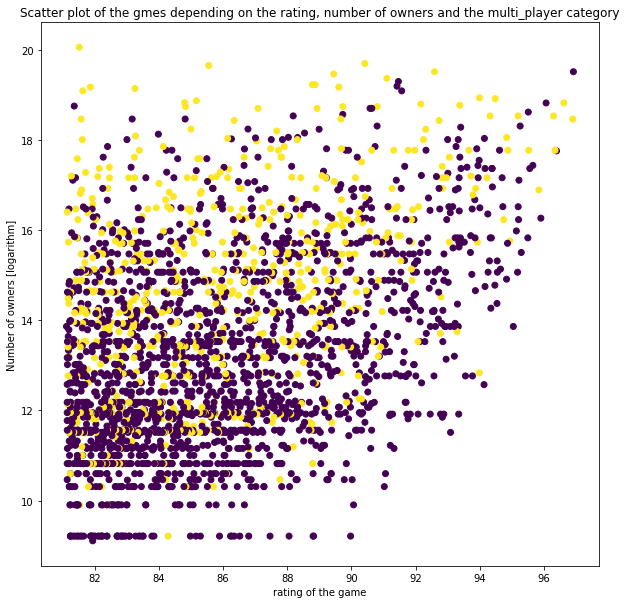

In [141]:
from sklearn.cluster import KMeans

plt.figure(1, figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("rating of the game")
plt.ylabel("Number of owners [logarithm]")
plt.title('Scatter plot of the gmes depending on the rating, number of owners and the ' +cat+" category")
plt.show()

In [142]:
sigma = np.std(pdist(X))
print(f'The value of sigma is {sigma}')

The value of sigma is 2.92852541993232


(array([2018366.,  767710.,  624250.,  550568.,  510348.,  482932.,
         464692.,  456878.,  457822.,  478534.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

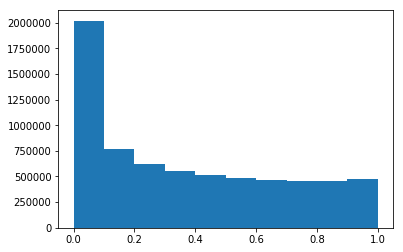

In [143]:
sq_dist = pdist(X)
pairwise_dists = squareform(sq_dist)**2
adjacency = np.exp( -pairwise_dists / sigma**2 / 2) - np.identity(len(pairwise_dists))
plt.hist(adjacency.flatten())

In [144]:
epsilon =0.85

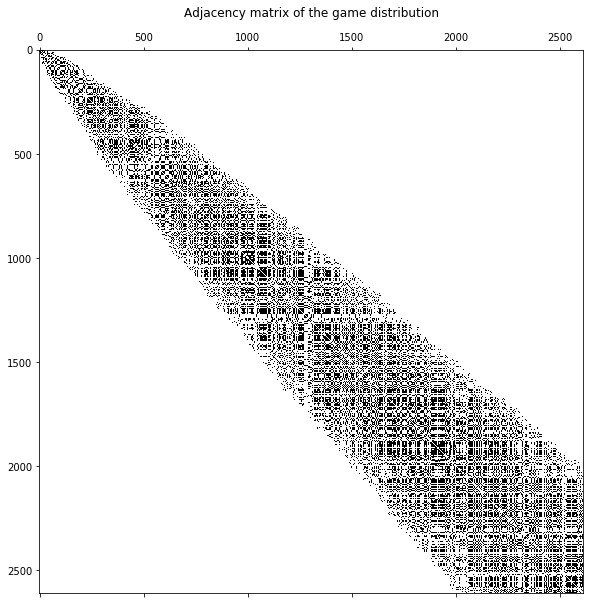

In [145]:
adjacency = epsilon_similarity_graph(X,sigma,epsilon)
plt.figure(1, figsize=(10, 10))
plt.spy(adjacency)

plt.title('Adjacency matrix of the game distribution')
plt.show()

In [146]:
Graph = nx.from_numpy_array(adjacency)
nodes1 = data[categories]

node_props = nodes1.to_dict()
for key in node_props:
    # print(key, node_props[key])
    nx.set_node_attributes(Graph, node_props[key], key)
    
nx.write_gexf(Graph, 'graphs/our_graph'+str(threshold)+'.gexf')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  after removing the cwd from sys.path.


## Analysis of the obtained graph 

(array([173., 270., 294., 356., 327., 311., 284., 224., 202., 169.]),
 array([  3.66034697,  55.56742048, 107.47449399, 159.3815675 ,
        211.288641  , 263.19571451, 315.10278802, 367.00986153,
        418.91693504, 470.82400854, 522.73108205]),
 <a list of 10 Patch objects>)

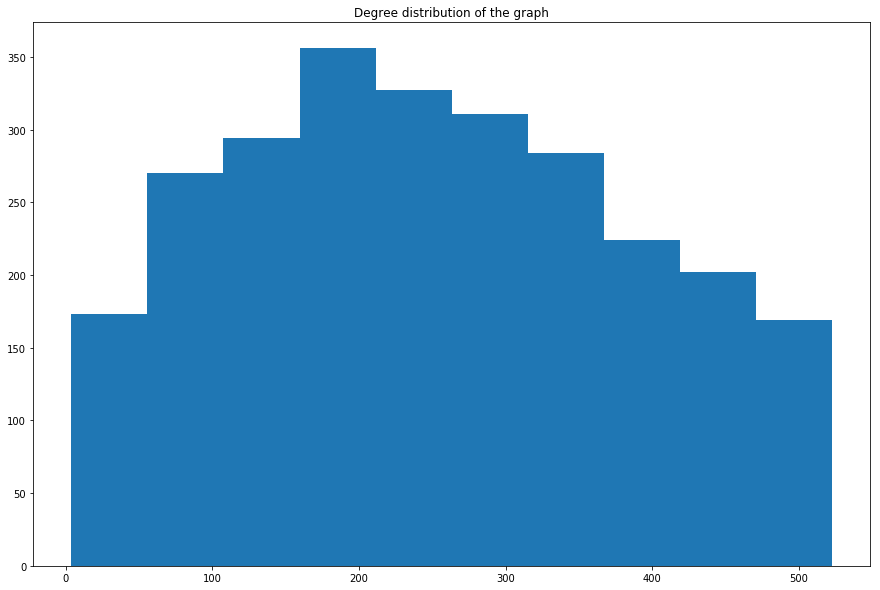

In [147]:
degrees_graph = np.sum(adjacency,axis=0) 

plt.figure(1, figsize=(15, 10))
plt.title('Degree distribution of the graph')
plt.hist(degrees_graph)

In [148]:
moment_1 = np.sum(np.nonzero(adjacency))/adjacency.shape[0]
moment_2 = np.sum( np.power(np.sum(np.nonzero(adjacency),0),2))/adjacency.shape[0]

print("Citation graph first moment:", moment_1)
print("Citation graph second moment:", moment_2)

Citation graph first moment: 834013.2344827587
Citation graph second moment: 2992429445.3386974


The moments are giving us an information about the distribution of the edges between the nodes. 

The moment of order 1 give an information on the dostribution of the graph while the moment of order 2 gives us an information on the variance of these connection. In our case, the variance of the distribution is really high and seems to be evenly connected.

In [149]:
num_edges = int(np.count_nonzero(adjacency)/2 )
print(f"Number of edges in the graph: {num_edges}")

Number of edges in the graph: 355482


In [150]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)


giant_component = max(connected_component_subgraphs(Graph), key=len) 
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_component.number_of_nodes(), giant_component.size()))

The giant component of the citation graph has 2610 nodes and 355482 edges.


From this, we can say that our grpah is fully connected. There is no clear separation different element. From those values and the results that we were able to export from our graph, we deduced that our graph is probably related to the **small world model**.

In [151]:
nx.average_clustering(Graph)

0.6540710150874428

The clustering coefficient gives us information on how much related are the points within the network. Indeed, it chooses each node at random and check its connectivity with two other nodes, forming a triangle. Then, it calculates the clustering coefficient by taking the mean of all the found clustering coefficient. In this case, the citation graph gives us a coefficient of approx. 63%, which means that a 2 third of the graph is connected. This result is going in the direction of our assumption for the small graph network. Our graph is not fully connected but all of the elements are connected between each others. 


## Spectral analysis 

**What we want to achieve:** We are trying to define a clustering technique based on the success of our game. Our metrics will be the logarithm of the average playtime and the rating. We decided not to use the economic success as we wanted to include the games that are free to play.

We will here use the preprocessed parameters that we previously used to cluster our data. Finally, we will analyze the results that we are obtaining and we will compare them with the graph obtained with gephi.

In [152]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    sq_dist = pdist(X)
    pairwise_dists = squareform(sq_dist)**2
    adjacency = np.exp( -pairwise_dists / (2*sigma**2) - np.identity(len(pairwise_dists)))

    threshold = adjacency < epsilon

    adjacency[threshold]=0
    
    return adjacency

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, U = np.linalg.eigh(laplacian)
    # Your code here
    return lamb, U

def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    return np.sum(lamb<threshold)

def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    distance = np.array([np.sum(adjacency,0)])
    laplacian = np.diag(distance[0]) - adjacency
    
    if (normalize):
        laplacian=np.power(distance,-1/2)*laplacian*np.power(distance,-1/2)
        laplacian[np.isnan(laplacian)] = 0
    return laplacian


class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method =  1# Your code here
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.laplacian = compute_laplacian(adjacency,self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)
        #self.U = self.U[np.argsort(self.e)]
        #self.U = np.flip(self.U)
    
    
        nb = compute_number_connected_components(self.e, threshold=10**(-10))
        if (self.normalize):
            T = self.U / np.linalg.norm(self.U, ord=2, axis=1, keepdims=True)  
            kmeans = KMeans(n_clusters=self.n_classes, n_init=20, max_iter=600, random_state=0).fit(T[:,:self.n_classes])
        else:
            kmeans = KMeans(n_clusters=self.n_classes, n_init=20, max_iter=600, random_state=0).fit(self.U[:,:self.n_classes])
        y_pred =  kmeans.labels_# Vector with cluster assignments
        return y_pred

In [153]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

In [154]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

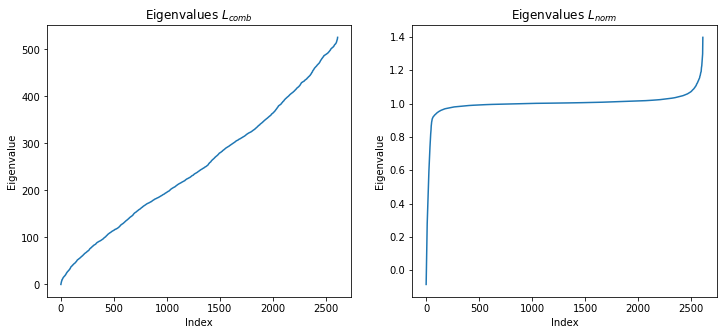

In [155]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.sort(lamb_comb))
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(np.sort(lamb_norm))
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [156]:
print(f'The lowest eigenvalue for the combinatorial Laplacian is {np.min(lamb_comb)}')
#print(f'Its corresponding eigenvector is {U_comb[np.argmin(lamb_comb)]}\n')
print(f'The lowest eigenvalue for the normalized Laplacian is {np.min(lamb_norm)}')
#print(f'Its corresponding eigenvector is {U_norm[np.argmin(lamb_norm)]}')

The lowest eigenvalue for the combinatorial Laplacian is -1.4274393554875086e-14
The lowest eigenvalue for the normalized Laplacian is -0.08493764959495262


In [157]:
print(compute_number_connected_components(lamb_norm, threshold=1e-11))

3


Connected components: 3


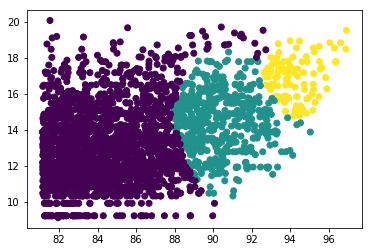

In [158]:
print("Connected components:", compute_number_connected_components(lamb_norm, threshold=1e-12))
spectral_clustering = SpectralClustering(n_classes=3, normalize=True)
y_pred = spectral_clustering.fit_predict(epsilon_similarity_graph(X, sigma=sigma, epsilon=epsilon))
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

## Analysis of our results and Conclusion 

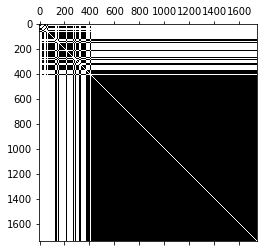

In [127]:
edges1 = np.zeros((len(y_pred),len(y_pred)))


for id1, y1 in enumerate(y_pred):
    for id2, y2 in enumerate(y_pred):
        edges1[id1,id2] = 1 if y1==y2 else 0 
        
edges1 = edges1 - np.eye(len(edges1))
        
plt.spy(edges1)
